In [1]:
import pandas as pd
import numpy as np

## Exploratory Data Analysis
Clean the dataset and find seasonalities

In [2]:
df = pd.read_csv('MTA_Subway_Ridership_Data_Clean.csv')
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df.set_index("Date", inplace=True)
df.rename(columns={
    "Subways: Total Estimated Ridership" : "Total Ridership",
    "Subways: % of Comparable Pre-Pandemic Day" : "Pre-Pandemic Ridership"
}, inplace=True)

In [3]:
df.head()

,Total Ridership,Pre-Pandemic Ridership
Date,,
2020-03-01,2212965,0.97
2020-03-02,5329915,0.96
2020-03-03,5481103,0.98
2020-03-04,5498809,0.99
2020-03-05,5496453,0.99


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

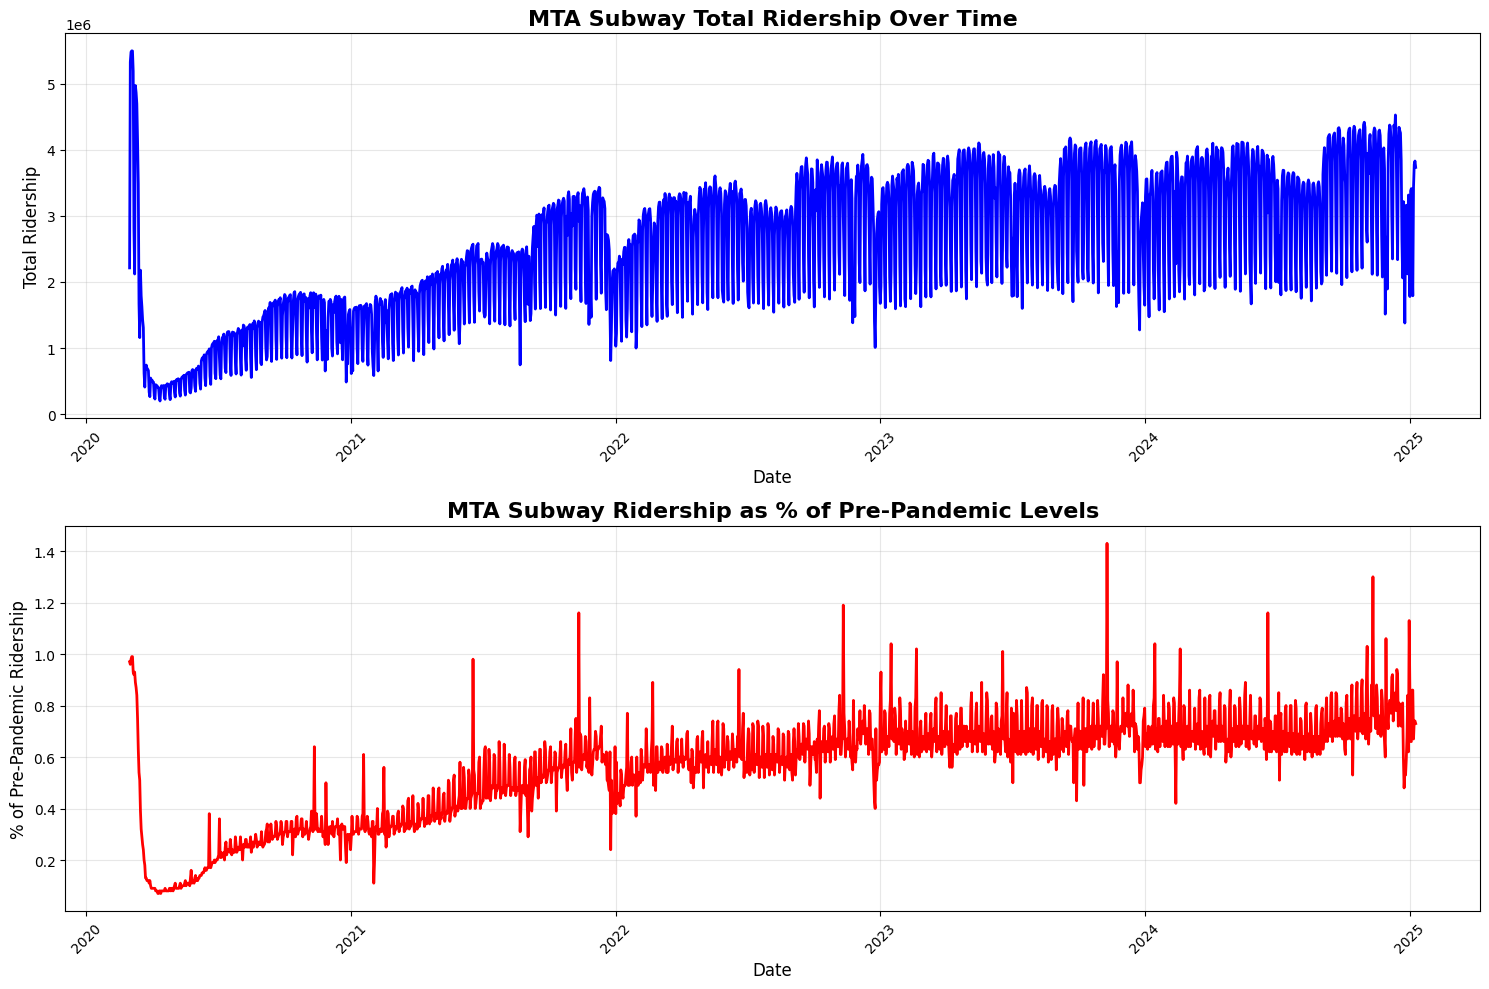

In [5]:
# Plot the ridership data
plt.figure(figsize=(15, 10))

# Plot 1: Total Ridership over time
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Total Ridership'], linewidth=2, color='blue')
plt.title('MTA Subway Total Ridership Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Ridership', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 2: Pre-Pandemic Ridership percentage over time
plt.subplot(2, 1, 2)
plt.plot(df.index, df['Pre-Pandemic Ridership'], linewidth=2, color='red')
plt.title('MTA Subway Ridership as % of Pre-Pandemic Levels', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('% of Pre-Pandemic Ridership', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [6]:
# Check data statistics to understand the range
print("Total Ridership Statistics:")
print(df['Total Ridership'].describe())
print("\nPre-Pandemic Ridership Statistics:")
print(df['Pre-Pandemic Ridership'].describe())

# Check for any extreme outliers
print(f"\nTotal Ridership - Min: {df['Total Ridership'].min()}, Max: {df['Total Ridership'].max()}")
print(f"Pre-Pandemic Ridership - Min: {df['Pre-Pandemic Ridership'].min()}, Max: {df['Pre-Pandemic Ridership'].max()}")


Total Ridership Statistics:
count    1.776000e+03
mean     2.541830e+06
std      1.067641e+06
min      1.983990e+05
25%      1.735692e+06
50%      2.505354e+06
75%      3.476191e+06
max      5.498809e+06
Name: Total Ridership, dtype: float64

Pre-Pandemic Ridership Statistics:
count    1776.000000
mean        0.563615
std         0.201075
min         0.070000
25%         0.420000
50%         0.610000
75%         0.700000
max         1.430000
Name: Pre-Pandemic Ridership, dtype: float64

Total Ridership - Min: 198399, Max: 5498809
Pre-Pandemic Ridership - Min: 0.07, Max: 1.43


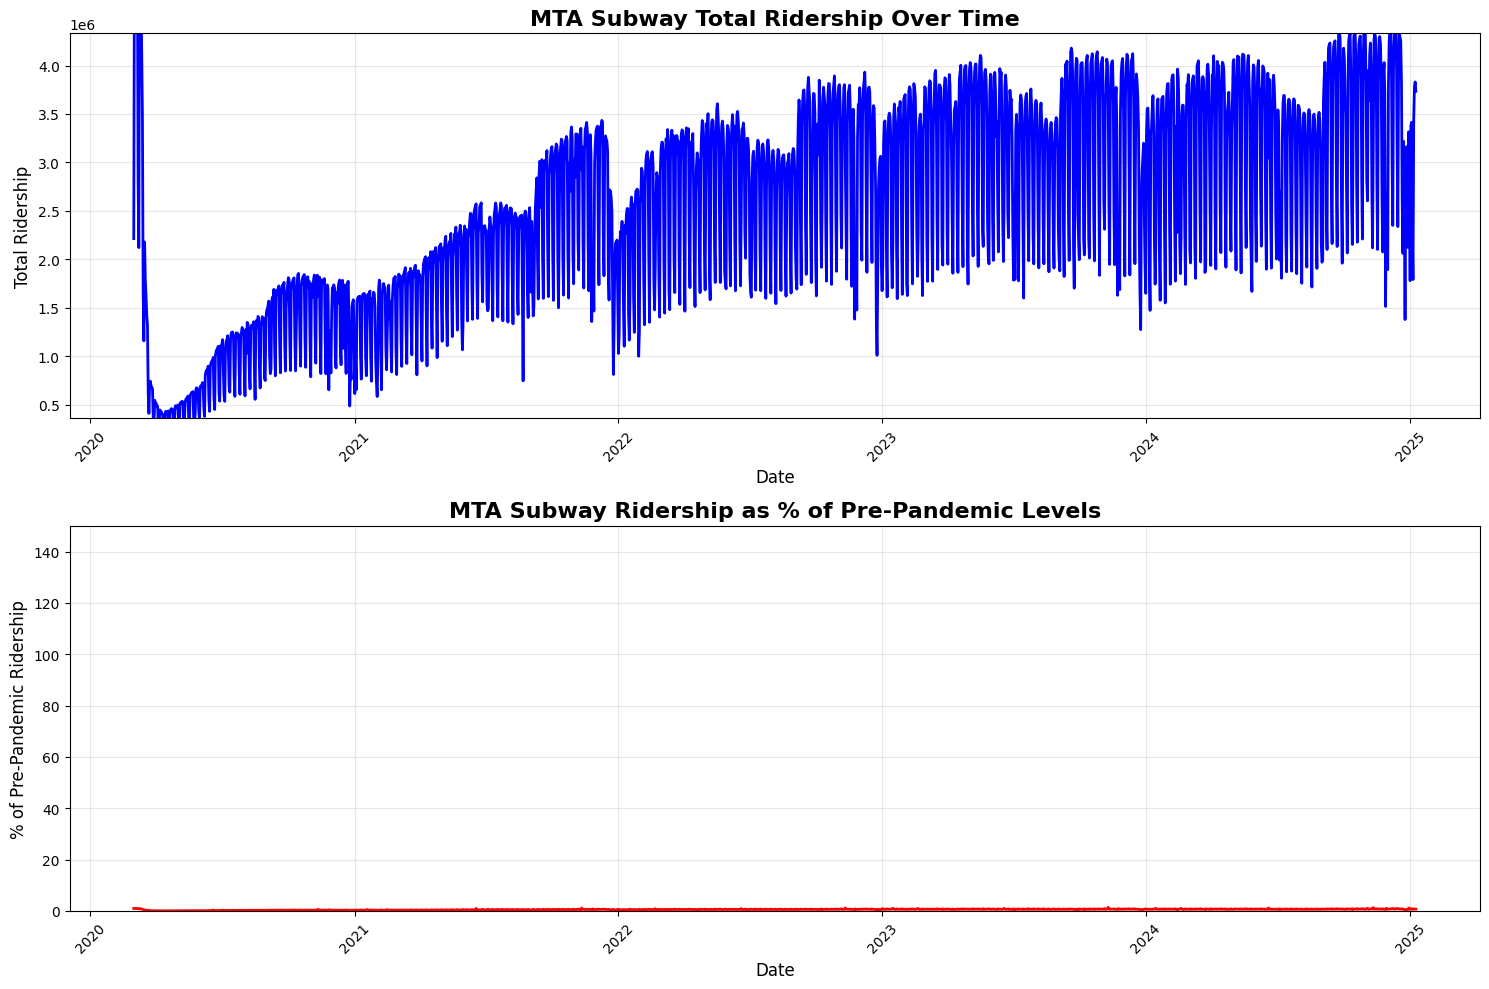

In [7]:
# Improved plot with better y-axis scaling
plt.figure(figsize=(15, 10))

# Plot 1: Total Ridership over time with adjusted y-axis
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Total Ridership'], linewidth=2, color='blue')
plt.title('MTA Subway Total Ridership Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Ridership', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Set y-axis limits to exclude extreme outliers (using percentiles)
q1 = df['Total Ridership'].quantile(0.01)  # 1st percentile
q99 = df['Total Ridership'].quantile(0.99)  # 99th percentile
plt.ylim(q1, q99)

# Plot 2: Pre-Pandemic Ridership percentage over time
plt.subplot(2, 1, 2)
plt.plot(df.index, df['Pre-Pandemic Ridership'], linewidth=2, color='red')
plt.title('MTA Subway Ridership as % of Pre-Pandemic Levels', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('% of Pre-Pandemic Ridership', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Set y-axis limits for percentage plot (typically 0-150% is reasonable)
plt.ylim(0, max(150, df['Pre-Pandemic Ridership'].quantile(0.99)))

plt.tight_layout()
plt.show()


From the plots above, we can see that there are yearly seasonalities, in addition to weekly seasonalities. Also, the year `2020` is an outlier because of the COVID pandemic. We will now see if the Box-Cox transform is needed

In [8]:
from scipy.stats import boxcox

_, LAMBDA = boxcox(df['Total Ridership'].values)
print(f"Estimated LAMBDA: {LAMBDA}")

Estimated LAMBDA: 0.9725707831410361


We see $\lambda \approx 0.9726$ which is very close to $1$, so the transform is not needed.

In [9]:
from scipy.optimize import minimize
from numpy.linalg import lstsq

In [10]:
def buildFreqs(periods, Ks):
    frequencies = []
    for m, k in zip(periods, Ks):
        for j in range(1, k+1):
            frequencies.append(2.0 * np.pi * j / m)
    return np.array(frequencies)

In [11]:
def OLSInit(Y, frequencies):
    N = len(Y)
    T = np.arange(N)
    X = np.column_stack([np.ones(N), T])
    if frequencies.size > 0:
        cos_cols = [np.cos(freq * T) for freq in frequencies]
        sin_cols = [np.sin(freq * T) for freq in frequencies]
        X = np.column_stack([X] + cos_cols + sin_cols)
    coeff, *_ = lstsq(X, Y, rcond=None)
    intercept, slope = coeff[0], coeff[1]
    H = len(frequencies)
    if H > 0:
        a0, b0 = coeff[2:2+H], coeff[2+H:2+2*H]
    else:
        a0, b0 = np.zeros(0), np.zeros(0)
    return intercept, slope, a0, b0


In [63]:
Seasonalities = [7]
Ks = [3, 3]
freqs = buildFreqs(Seasonalities, Ks)

In [64]:
intercept, slope, a0, b0 = OLSInit(df['Total Ridership'].values.astype(float), freqs)
print(f"Intercept: {intercept}\nSlope: {slope}\na0: {a0}\nb0: {b0}")

Intercept: 1291180.2927792915
Slope: 1408.951373263167
a0: [-664965.83284413 -277820.15550555  -87702.85962736]
b0: [207370.11379446 176567.73125255  71279.75337412]


We can fit the **OLS** (Ordinary Least Squares) curve to our data

In [65]:
def fitOLS(y, freqs, intercept, slope, a0, b0):
    N = len(y)
    T = np.arange(N)
    fit = intercept + slope * T
    if freqs.size > 0:
        for j, lmbda in enumerate(freqs):
            fit += a0[j] * np.cos(lmbda * T) + b0[j] * np.sin(lmbda * T)
    return fit

Text(0, 0.5, 'Total Ridership')

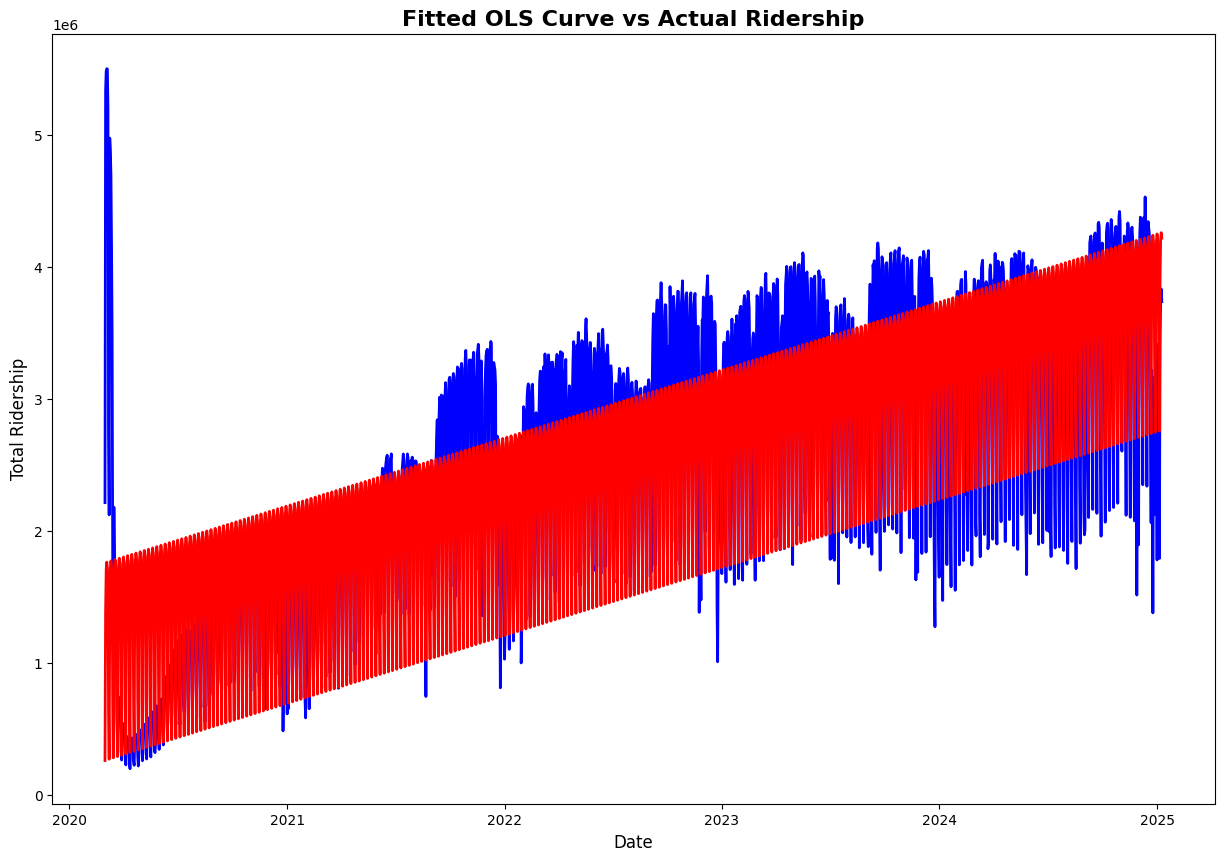

In [66]:
fittedVals = fitOLS(df['Total Ridership'].values, freqs, intercept, slope, a0, b0)
plt.figure(figsize=(15, 10))
plt.plot(df.index, df['Total Ridership'], linewidth=2, color='blue', label='Actual Ridership')
plt.plot(df.index, fittedVals, linewidth=2, color='red', label='Fitted OLS Curve')
plt.title('Fitted OLS Curve vs Actual Ridership', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Ridership', fontsize=12)

We can see that the **OLS** curve does a pretty good job of fitting the ridership data, with the exception of the peak before the drop in ridership due to the COVID pandemic.

In [67]:
def rotationMatrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

In [68]:
def fitTBATSInitial(y, freqs, initState, initParams):
    r"""
    TBATS-style recursion without ARMA.
    
    Inputs:
      y           : 1D numpy array of observations
      freqs       : array of seasonal frequencies λ_j = 2πj/m
      init_states : dict with keys:
                      'level', 'trend', 'a', 'b'
                    where a and b are arrays for seasonal harmonics
      params      : dict with keys:
                      'alpha', 'beta', 'phi', 'deltas'
                    where deltas is an array (len = len(freqs))
    
    Returns:
      fitted      : one-step-ahead predictions
      residuals   : e_t = y_t - ŷ_t
      final_states: dict of last (level, trend, a, b)
    """
    N, H = len(y), len(freqs)
    alpha, beta, phi = initParams['alpha'], initParams['beta'], initParams['phi']
    deltas = np.array(initParams['deltas']) if H > 0 else np.zeros(0)
    level, trend = initState['level'], initState['trend']
    a = initState['a'].copy() if H > 0 else np.zeros(0)
    b = initState['b'].copy() if H > 0 else np.zeros(0)
    fitted = np.zeros(N)
    residuals = np.zeros(N)

    for t in range(N):
        seasonal = 0.0
        if H > 0:
            angles = freqs * t
            seasonal = np.sum(a * np.cos(angles) + b * np.sin(angles))
        y_hat = level + phi * trend + seasonal
        fitted[t] = y_hat
        residuals[t] = y[t] - y_hat
        level_new = level + phi * trend + alpha * residuals[t]
        trend_new = phi * trend + beta * residuals[t]

        if H > 0:
            for j, lmbda in enumerate(freqs):
                R = rotationMatrix(lmbda)
                vec_prev = np.array([a[j], b[j]])
                vec_new = R.dot(vec_prev) + deltas[j] * residuals[t] * np.array([1.0, 0.0])
                a[j], b[j] = vec_new

        level, trend = level_new, trend_new
    final_states = {
        'level': level,
        'trend': trend,
        'a': a.copy(),
        'b': b.copy()
    }
    return fitted, residuals, final_states
        
        
        

In [69]:
INIT_STATES = {
    'level' : intercept,
    'trend' : slope,
    'a' : a0,
    'b' : b0
}

In [70]:
INIT_PARAMS = {
    'alpha': 0.1,                 # smoothing for level
    'beta': 0.01,                 # smoothing for trend
    'phi': 0.98,                  # damping
    'deltas': np.concatenate([np.repeat(0.01, 6), np.repeat(0.002, 3)])
}


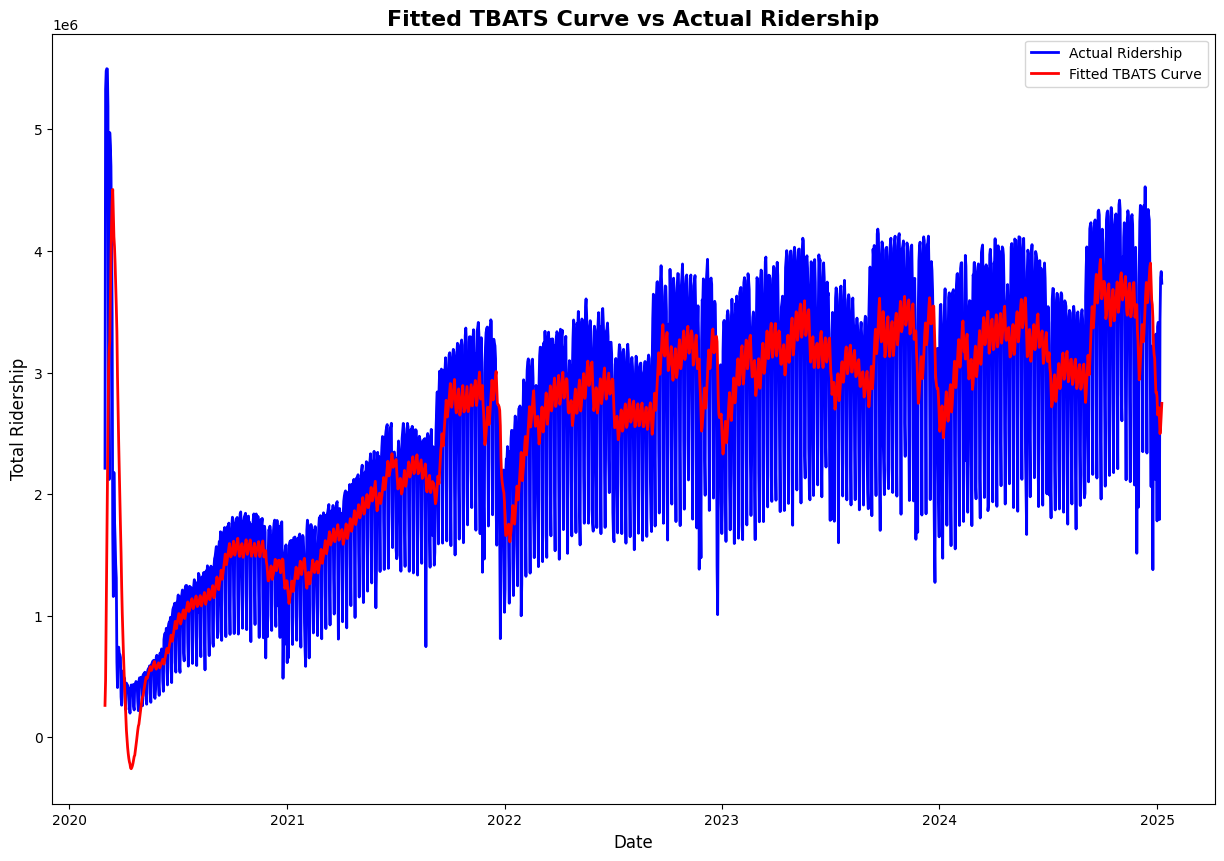

In [71]:
fitted, residuals, final_states = fitTBATSInitial(
    df['Total Ridership'].values.astype(float),
    freqs,
    INIT_STATES,
    INIT_PARAMS
)

plt.figure(figsize=(15, 10))
plt.plot(df.index, df['Total Ridership'], linewidth=2, color='blue', label='Actual Ridership')
plt.plot(df.index, fitted, linewidth=2, color='red', label='Fitted TBATS Curve')
plt.title('Fitted TBATS Curve vs Actual Ridership', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Ridership', fontsize=12)
plt.legend()
plt.show()

We can see that the recursion curve (red) is tracking the ridership curve (blue) pretty well. The big drop in $2020$ due to COVID is being absorbed decently.
However, the fitted curve is a little smoothed out compared to the real spikes. We now need to examine the residuals to see if ARMA  **(Automated Regressive Moving Average)** is needed

In [72]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [73]:
def checkResiduals(residuals, lags: int=40):
    figx, ax = plt.subplots(3, 1, figsize=(15, 10))
    ax[0].plot(residuals, linewidth=2, color='blue')
    ax[0].axhline(0, color='black', linestyle='--')
    plot_acf(residuals, lags=lags, ax=ax[1], title='ACF of Residuals')
    plot_pacf(residuals, lags=lags, ax=ax[2], title='PACF of Residuals')
    plt.tight_layout()
    plt.show()

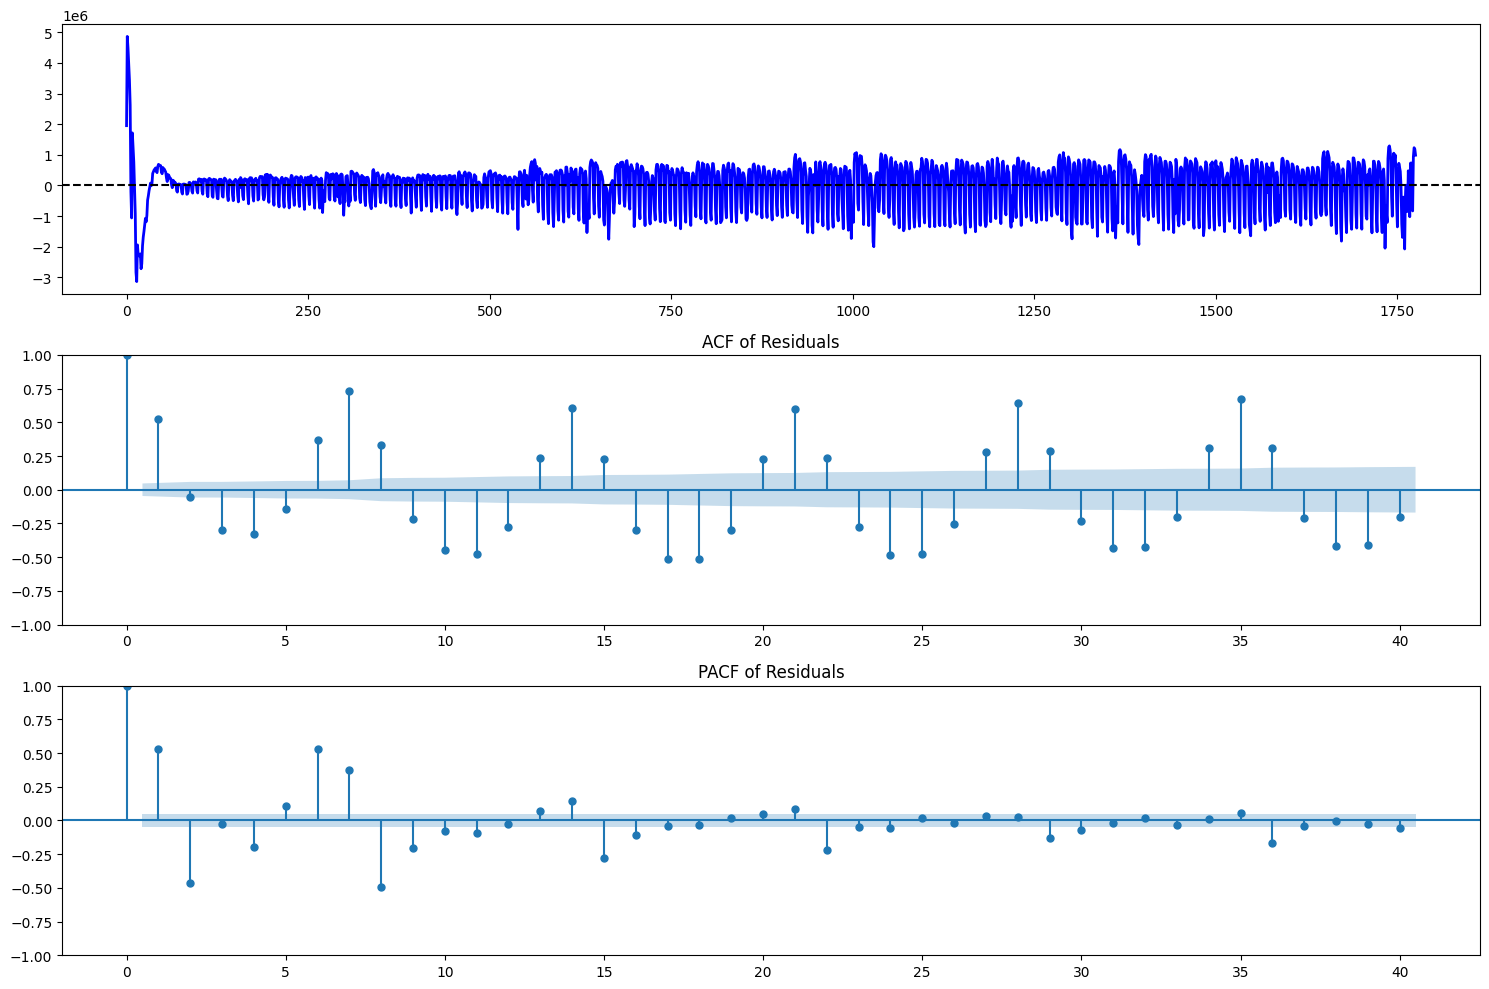

In [74]:
checkResiduals(residuals)

Looking at the **ACF (Autocorrelation function) of Residuals**, we can see that there is a big spike at $\text{lag} = 1$, and noticeable structure around $\text{lag} = 7,14$ which suggests weekly pattern echoing. Looking at the **PACF (Partial ACF)**, we can see a strong spike at $\text{lag} = 1$ which then dies down.   
**This is classic $AR(1)$ behavior**

In [75]:
from statsmodels.tsa.stattools import acf

r1 = acf(residuals, nlags=1, fft=False)[1]
print("sample lag-1 autocorr (r1) =", r1)

sample lag-1 autocorr (r1) = 0.5266401646097425


In [76]:
def rotateSeasonal(a, b, lmbda, delta, u):
    r"""
    Rotate seasonal harmonics by angle lmbda.
    
    Inputs:
      a, b      : arrays of seasonal harmonics
      lmbda     : angle of rotation
      delta     : seasonal smoothing
      u         : innovation
    
    Returns:
      a_new, b_new : rotated seasonal harmonics
    """
    C, S = np.cos(lmbda), np.sin(lmbda)
    a_new = C*a  + S*b + delta*u
    b_new = -S*a + C*b
    return a_new, b_new


In [77]:
def fitTBATSWithAR1(y, freqs, initState, initParams, storeHistory: bool=True):
    r"""
    Fit TBATS model with AR(1) error structure.
    
    Inputs:
      y           : 1D numpy array of observations
      freqs       : array of seasonal frequencies λ_j = 2πj/m
      init_states : dict with keys:
                      'level', 'trend', 'a', 'b'
                    where a and b are arrays for seasonal harmonics
      params      : dict with keys:
                      'alpha', 'beta', 'phi', 'deltas', 'rho'
                    where deltas is an array (len = len(freqs)) and rho is the AR(1) coefficient
    
    Returns:
      fitted      : one-step-ahead predictions
      residuals   : e_t = y_t - ŷ_t
      final_states: dict of last (level, trend, a, b)
      innov       : innovations e_t = y_t - ŷ_t
      history     : dict of (level, trend, a, b) at each step

    """

    N = len(y)
    H = len(freqs)
    alpha, beta, phi, rho = initParams['alpha'], initParams['beta'], initParams['phi'], initParams['rho']
    deltas = np.array(initParams['deltas']) if H > 0 else np.zeros(0)
    level, trend = initState['level'], initState['trend']
    a = initState['a'].copy() if H > 0 else np.zeros(0)
    b = initState['b'].copy() if H > 0 else np.zeros(0)
    fitted = np.zeros(N)
    innov = np.zeros(N)
    eps = np.zeros(N)
    if storeHistory:
        levelHistory = np.zeros(N)
        trendHistory = np.zeros(N)
        aHistory = np.zeros((N, H)) if H > 0 else None
        bHistory = np.zeros((N, H)) if H > 0 else None

    eps_prev = 0.0
    for t in range(N):
        if H > 0:
            seasonal = np.sum(a * np.cos(freqs * t) + b * np.sin(freqs * t))
        else:
            seasonal = 0.0
        y_hat = level + phi * trend + seasonal
        fitted[t] = y_hat
        eps[t] = y[t] - y_hat
        innov[t] = eps[t] - rho * eps_prev
        if storeHistory:
            levelHistory[t] = level
            trendHistory[t] = trend
            if H > 0:
                aHistory[t, :] = a
                bHistory[t, :] = b
        level_new = level + phi * trend + alpha * innov[t]
        trend_new = phi * trend + beta * innov[t]
        if H > 0:
            for j, lmbda in enumerate(freqs):
                a[j], b[j] = rotateSeasonal(a[j], b[j], lmbda, deltas[j], innov[t])
        level, trend = level_new, trend_new
        eps_prev = eps[t]

    final_states = {
        'level': level,
        'trend': trend,
        'a': a.copy(),
        'b': b.copy()
    }
    results = {
      'fitted': fitted,
      'eps': eps,
      'innov': innov,
      'final_states': final_states
    }
    if storeHistory:
        results['history'] = {
            'level': levelHistory,
            'trend': trendHistory,
            'a': aHistory,
            'b': bHistory
        }
    return results
        
        

In [78]:
AR1_PARAMS = {
    'alpha': 0.01,     # small level gain
    'beta': 0.001,     # tiny trend gain
    'phi': 0.98,       # keep near 1 for slow trend damping
    'deltas': np.concatenate([np.repeat(0.00075, 6), np.repeat(0.001, 3)]),
    'rho': r1
}

In [79]:
results = fitTBATSWithAR1(
    df['Total Ridership'].values.astype(float),
    freqs,
    INIT_STATES,
    AR1_PARAMS,
    storeHistory=True
)

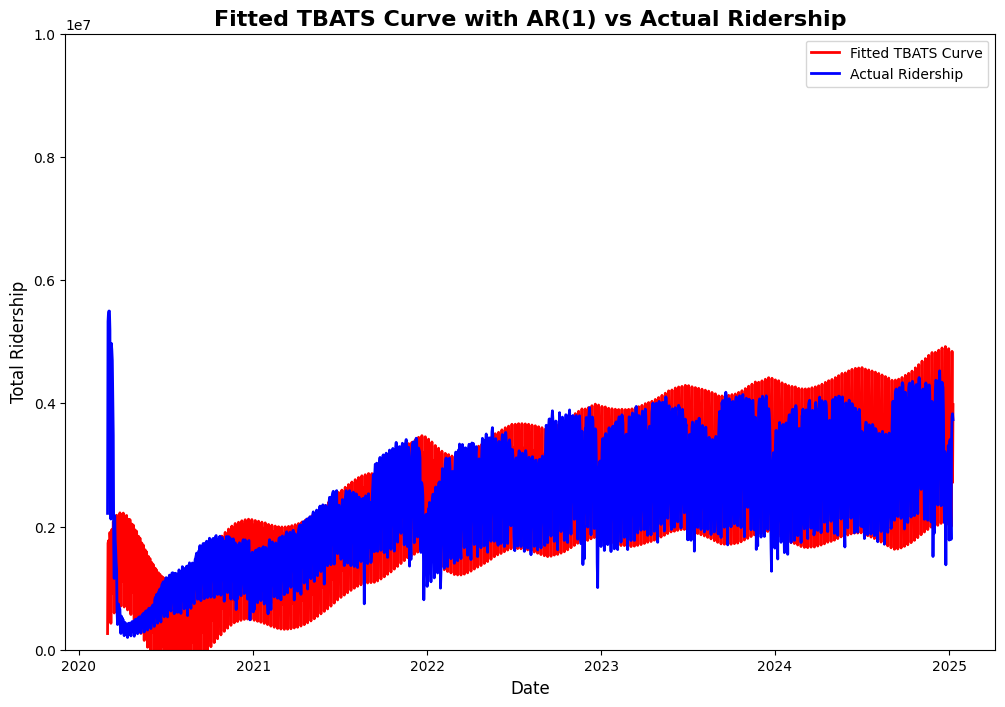

In [80]:
plt.figure(figsize=(12, 8))
plt.ylim(0, 1e7)
plt.plot(df.index, results['fitted'], linewidth=2, color='red', label='Fitted TBATS Curve')
plt.plot(df.index, df['Total Ridership'], linewidth=2, color='blue', label='Actual Ridership')
plt.title('Fitted TBATS Curve with AR(1) vs Actual Ridership', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Ridership', fontsize=12)
plt.legend()
plt.show()

After adding the $AR(1)$ term, we can see that the fitted curve (red) better captures the shape of the real data (blue).
However, we notice that the blue curve lags a bit behind the red in terms of peaks and troughs.
We will need to optimize the parameters to obtain a better fit.

In [81]:
from scipy.optimize import minimize


In [82]:
def optimizeAR1Params(y, freqs, initStates, theta0=None, bounds=None, method='L-BFGS-B', options=None, clip_rho=True):
    """
    Estimate TBATS-like smoothing params + AR1 by minimizing SSE of innovations.
    Inputs:
      - y_array: 1D numpy array (observations)
      - freqs: 1D numpy array of angular frequencies (lambda_j)
      - init_states: {'level', 'trend', 'a', 'b'} from OLS init
      - theta0: optional initial vector [alpha, beta, phi, delta_1..delta_H, rho]
      - bounds: optional list of (low, high) for each theta element (overrides sensible defaults)
      - method: optimizer method (L-BFGS-B recommended)
      - opt_options: dict forwarded to scipy.optimize.minimize
      - clip_rho: if True, automatically clip initial rho into (-0.99,0.99)
    Returns:
      dict with keys:
        'theta_hat' : estimated parameter vector
        'params'    : dict {'alpha','beta','phi','deltas','rho'}
        'opt_res'   : scipy OptimizeResult
        'recursion' : output of run_recursion_ar1(y_array, freqs, init_states, params_hat)
    Notes:
      - Minimizes SSE of innovations u_t (which is equivalent to MLE with Gaussian u_t up to sigma2).
      - Make sure run_recursion_ar1 is defined and returns 'innov' in its result.
    """
    H = len(freqs)
    n_params = 3 + H + 1
    if theta0 is None:
        alpha0, beta0, phi0 = 0.02, 0.002, 0.98
        delta0 = np.repeat(0.002, H) if H > 0 else np.array([])
        try:
            r1 = acf(y, nlags=1, fft=False)[1]
            r1 = float(np.clip(r1, -0.95, 0.95))
        except Exception: r1 = 0.3
        rho0 = r1
        theta0 = np.concatenate([[alpha0, beta0, phi0], delta0, [rho0]])
    else:
        theta0 = np.asarray(theta0, dtype=float)
        if clip_rho: theta0[-1] = float(np.clip(theta0[-1], -0.95, 0.95))
    if bounds is None:
        bnds = []
        bnds.append((1e-6, 1e-5)) # FOR ALPHA
        bnds.append((0.0, 0.5)) # FOR BETA
        bnds.append((0.6, 0.9999)) # FOR PHI
        for _ in range(H): bnds.append((0.0, 0.5)) # FOR DELTA
        bnds.append((-0.99, 0.99)) # for rho
    else:
        nmds = bounds

    def objective(theta):
        alpha = float(theta[0])
        beta = float(theta[1])
        phi = float(theta[2])
        if H > 0:
            deltas = np.array(theta[3:3+H], dtype=float)
            rho = float(theta[-1])
        else:
            deltas = np.array([])
            rho = float(theta[-1])
        params = {
            'alpha': alpha,
            'beta': beta,
            'phi': phi,
            'deltas': deltas,
            'rho': rho
        }
        recursion = fitTBATSWithAR1(y, freqs, initStates, params, storeHistory=False)
        innov = np.asarray(recursion['innov'])
        if not np.all(np.isfinite(innov)): return 1e12
        innov = np.clip(innov, -1e6, 1e6)
        sse = float(np.sum(innov**2) + 1e-9) # add small epsilon to avoid log(0)
        return sse
    
    if options is None: options = {'maxiter' : 505, 'ftol' : 1e-8}
    opt_res = minimize(objective, theta0, method=method, bounds=bnds, options=options)
    theta_hat = opt_res.x
    alpha_hat, beta_hat, phi_hat = theta_hat[:3]
    if H > 0:
        deltas_hat = np.array(theta_hat[3:3+H])
        rho_hat = float(theta_hat[-1])
    else:
        deltas_hat = np.array([])
        rho_hat = float(theta_hat[-1])
    
    params_hat = {
        'alpha' : alpha_hat,
        'beta' : beta_hat,
        'phi' : phi_hat,
        'deltas' : deltas_hat,
        'rho' : rho_hat
    }
    recursion = fitTBATSWithAR1(y, freqs, initStates, params_hat, storeHistory=True)
    return {
        'theta_hat' : theta_hat,
        'params' : params_hat,
        'opt_res' : opt_res,
        'recursion' : recursion
    }

In [86]:
optimizedResults = optimizeAR1Params(
    df['Total Ridership'].values.astype(float),
    freqs,
    INIT_STATES,
    theta0=[
        0.02,
        0.002,
        0.98,
        *np.repeat(0.001, 3),
        0.3
    ],
    bounds=None,
    method='L-BFGS-B'
)

In [87]:
print("Estimated parameters:")
print(f"alpha: {optimizedResults['params']['alpha']:.4f}")
print(f"beta: {optimizedResults['params']['beta']:.4f}")
print(f"phi: {optimizedResults['params']['phi']:.4f}")
print(f"deltas: {optimizedResults['params']['deltas']}")
print(f"rho: {optimizedResults['params']['rho']:.4f}")


Estimated parameters:
alpha: 0.0000
beta: 0.0671
phi: 0.6314
deltas: [0.         0.         0.00452468]
rho: -0.0987


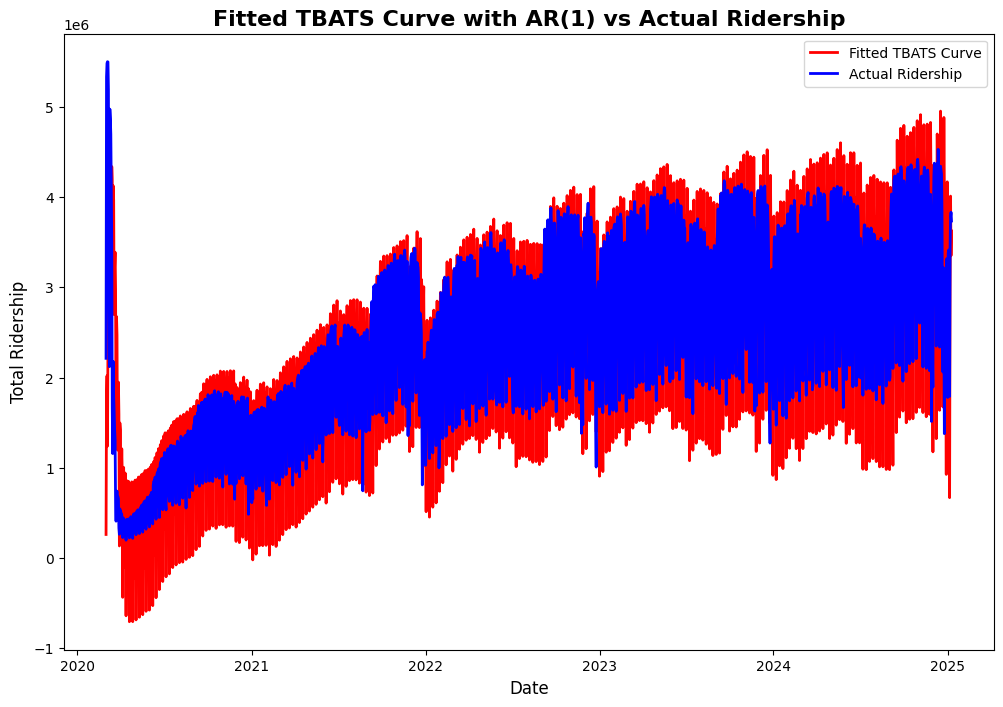

In [88]:
recursion = optimizedResults['recursion']
fitted = recursion['fitted']
innov = recursion['innov']  

plt.figure(figsize=(12, 8))
plt.plot(df.index, fitted, linewidth=2, color='red', label='Fitted TBATS Curve')
plt.plot(df.index, df['Total Ridership'], linewidth=2, color='blue', label='Actual Ridership')
plt.title('Fitted TBATS Curve with AR(1) vs Actual Ridership', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Ridership', fontsize=12)
plt.legend()
plt.show()

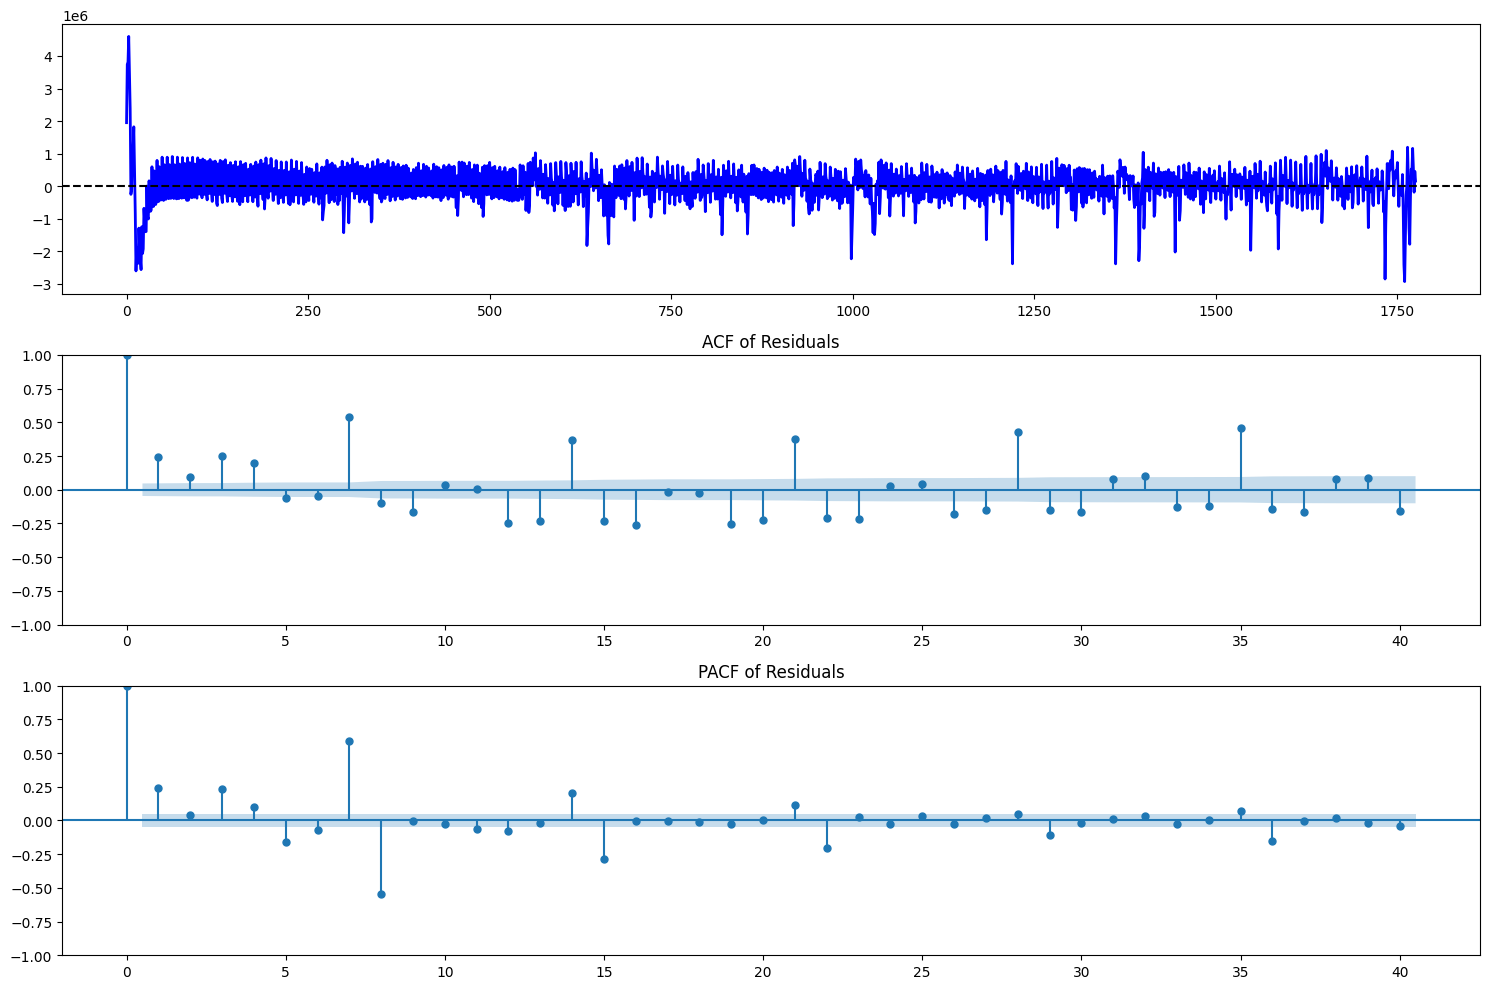

In [89]:
checkResiduals(innov)

A bit better, but sometimes the TBATS curve dips into the negatives, which is junk information as ridership cannot be negative.
Let's try with a premade **TBATS** model from `statsforecast` and see how it does

In [36]:
from statsforecast.models import TBATS
from statsforecast import StatsForecast

In [58]:
SF = StatsForecast(
    models = [TBATS(season_length=[7], use_arma_errors=True)],
    freq = 'D',
    n_jobs = -1
)

In [48]:
SFDF = pd.DataFrame({
    'ds' : df.index,
    'y' : df['Total Ridership'].values.astype(float),
    'unique_id' : 'Total Ridership'
})

SFDF.head()

,ds,y,unique_id
0,2020-03-01,2212965.0,Total Ridership
1,2020-03-02,5329915.0,Total Ridership
2,2020-03-03,5481103.0,Total Ridership
3,2020-03-04,5498809.0,Total Ridership
4,2020-03-05,5496453.0,Total Ridership


In [59]:
forecast = SF.forecast(df=SFDF, h=14)

In [60]:
forecast.head()

,unique_id,ds,TBATS
0,Total Ridership,2025-01-10,3.545747e+06
1,Total Ridership,2025-01-11,2.392794e+06
2,Total Ridership,2025-01-12,1.891312e+06
3,Total Ridership,2025-01-13,3.301788e+06
4,Total Ridership,2025-01-14,3.718655e+06


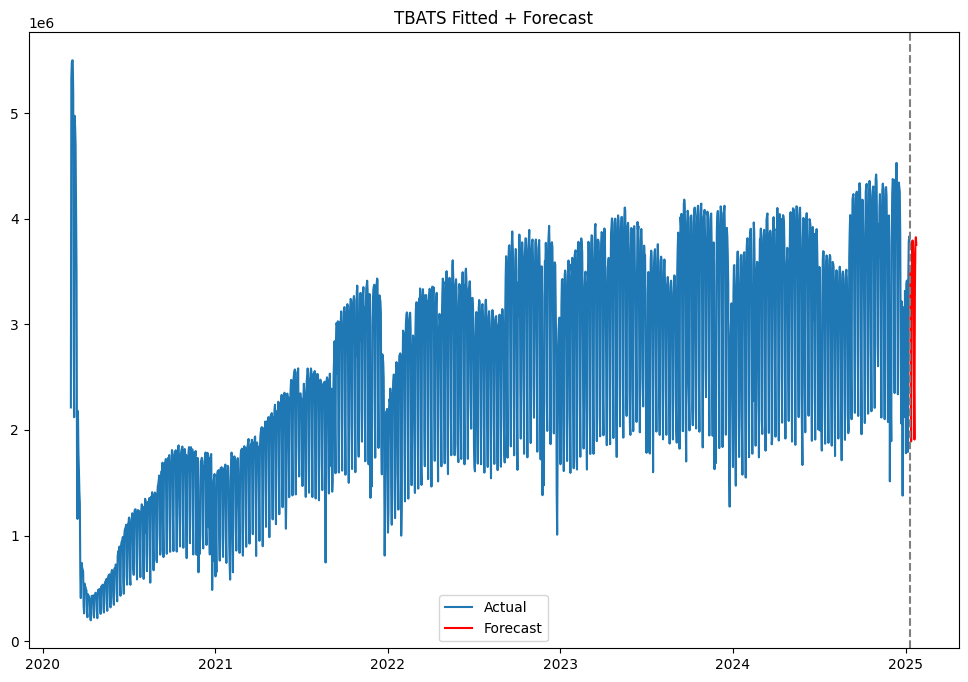

In [61]:
plt.figure(figsize=(12,8))
# Actual history
plt.plot(SFDF['ds'], SFDF['y'], label='Actual')
# Forecast part
plt.plot(forecast['ds'], forecast['TBATS'], label='Forecast', color='red')
plt.axvline(SFDF['ds'].iloc[-1], color='gray', linestyle='--')  # split line
plt.legend()
plt.title("TBATS Fitted + Forecast")
plt.show()


In [62]:
forecast.head(14)

,unique_id,ds,TBATS
0,Total Ridership,2025-01-10,3.545747e+06
1,Total Ridership,2025-01-11,2.392794e+06
2,Total Ridership,2025-01-12,1.891312e+06
3,Total Ridership,2025-01-13,3.301788e+06
4,Total Ridership,2025-01-14,3.718655e+06
5,Total Ridership,2025-01-15,3.793354e+06
6,Total Ridership,2025-01-16,3.722254e+06
7,Total Ridership,2025-01-17,3.579190e+06
8,Total Ridership,2025-01-18,2.418278e+06
9,Total Ridership,2025-01-19,1.908991e+06


The yearly seasonality was removed and the model is predicting future data very well.